# Sankt Nikolaus Rally

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

import available as avb
import utils as self_utils
from quantified_strategies import utils

C:\Users\tomw1\AppData\Local\Temp\ipykernel_3732\15359.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
START = dt.date(2015, 1, 1)
END = dt.date.today()

XDAY = 4
ENTER_ON_N_XDAY_OF_DEC = 3

## Rules

1. Buy on the third Friday in December (when DAX futures expire)
2. Close position on the last trading day of the year.

In [3]:
TICKER = "^FTSE"
TICKER = "EWG"
TICKER = "FEZ"
TICKER = "^FCHI"
TICKER = "NXT.L"

In [4]:
data = yf.download(TICKER, progress=False)["Adj Close"].to_frame(name=TICKER)
data.head(5)

C:\Users\tomw1\AppData\Local\pypoetry\Cache\virtualenvs\quantified-strategies-wFBlb7GR-py3.11\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,NXT.L
Date,
1988-07-01,99.147736
1988-07-04,98.360840
1988-07-05,97.967407
1988-07-06,96.393639
1988-07-07,95.213295


In [5]:
data = data.loc[(data.index.date >= START) & (data.index.date <= END)]
data.head(5)

,NXT.L
Date,
2015-01-02,5074.539062
2015-01-05,5063.269531
2015-01-06,5063.269531
2015-01-07,5145.906250
2015-01-08,5187.222168


### Get entrance px

In [6]:
december_data = data.loc[data.index.month == 12].copy()
xday_data = december_data.loc[december_data.index.weekday == XDAY].copy()
xday_data["year"] = xday_data.index.year

first_n_xdays_in_dec = xday_data.groupby("year").head(ENTER_ON_N_XDAY_OF_DEC)
nth_xday_in_dec = first_n_xdays_in_dec.groupby("year").tail(1)

entrance_px = nth_xday_in_dec.set_index("year")[TICKER].to_frame(name="enter")
entrance_px.head(5)

,enter
year,
2015,5679.682129
2016,4030.806396
2017,3610.453613
2018,3632.291016
2019,6384.106445


### Get exit px

In [7]:
last_trading_day_of_year = data.resample("YE").last()
exit_px = last_trading_day_of_year.rename(columns={TICKER: "exit"})
exit_px.index = exit_px.index.year
exit_px.index.name = "year"
exit_px.head(5)

,exit
year,
2015,5691.392090
2016,4057.678467
2017,3847.692871
2018,3527.122070
2019,6384.106445


### Join Data

In [8]:
df = pd.concat([entrance_px, exit_px], axis=1)
df.index = df.index.map(lambda year: pd.Timestamp(dt.date(year, 12, 31)))
df.head(5)

,enter,exit
year,,
2015-12-31,5679.682129,5691.392090
2016-12-31,4030.806396,4057.678467
2017-12-31,3610.453613,3847.692871
2018-12-31,3632.291016,3527.122070
2019-12-31,6384.106445,6384.106445


In [9]:
df["ret"] = (df["exit"] / df["enter"] - 1)
df["cumret"] = utils.get_cumulative_return(df["ret"], total=False)

In [10]:
df

,enter,exit,ret,cumret
year,,,,
2015-12-31,5679.682129,5691.392090,0.002062,0.002062
2016-12-31,4030.806396,4057.678467,0.006667,0.008742
2017-12-31,3610.453613,3847.692871,0.065709,0.075026
2018-12-31,3632.291016,3527.122070,-0.028954,0.043899
2019-12-31,6384.106445,6384.106445,0.000000,0.043899
2020-12-31,6171.242188,6445.964844,0.044517,0.090370
2021-12-31,7167.532227,7516.133301,0.048636,0.143402
2022-12-31,5467.949707,5642.893066,0.031994,0.179984
2023-12-31,8154.000000,8118.000000,-0.004415,0.174774


In [11]:
df1 = self_utils.run(ticker=TICKER, start=START, end=END, full=True)

In [13]:
5691.392090 / 5679.682129 - 1

0.0020617282330308573

In [16]:
df1

,asset,ret,ret_shifted,active,strat_ret,cum_strat_ret,cum_hodl_ret,enter_flag,trade_number,ret2
Date,,,,,,,,,,
2015-01-02,5074.538574,NaN,-0.002220,False,-0.0,0.000000,-0.002220,False,0,NaN
2015-01-05,5063.270996,-0.002220,0.000000,False,0.0,0.000000,-0.002220,False,0,-0.002220
2015-01-06,5063.270996,0.000000,0.016320,False,0.0,0.000000,0.014064,False,0,0.000000
2015-01-07,5145.905273,0.016320,0.008029,False,0.0,0.000000,0.022206,False,0,0.016320
2015-01-08,5187.223145,0.008029,-0.002172,False,-0.0,0.000000,0.019985,False,0,0.008029
...,...,...,...,...,...,...,...,...,...,...
2024-02-12,8348.000000,0.015325,-0.020604,False,-0.0,0.174774,0.611181,False,9,0.015325
2024-02-13,8176.000000,-0.020604,0.014677,False,0.0,0.174774,0.634828,False,9,-0.020604
2024-02-14,8296.000000,0.014677,0.012536,False,0.0,0.174774,0.655323,False,9,0.014677


## Plot Strategy Results

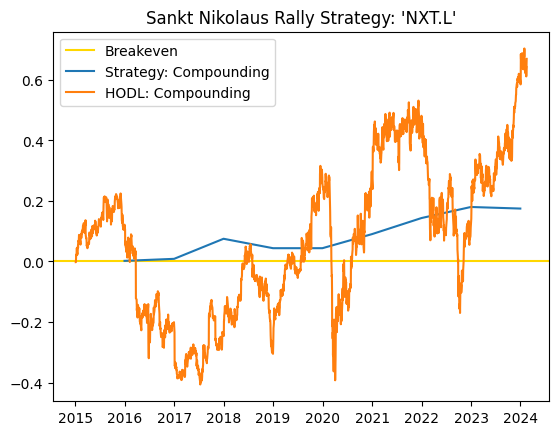

In [15]:
fig, ax = plt.subplots()

ax.axhline(y=0, label="Breakeven", color="gold")

ax.plot(df["cumret"], label="Strategy: Compounding")
# ax.plot(df["ret"].cumsum(), label="Strategy: Cumulative")
ax.plot(utils.get_cumulative_return(returns=data[TICKER].pct_change(), total=False), label="HODL: Compounding")
# ax.plot(data[TICKER].pct_change().cumsum(), label="HODL: Cumulative")

plt.title(f"Sankt Nikolaus Rally Strategy: {TICKER!r}")
plt.legend(loc="best")
plt.show()

## Describe Strategy Results

In [82]:
utils.describe(returns=df["ret"], daily=False, asset=TICKER)

Asset                          NXT.L
Start                     2015-12-31
End                       2024-12-31
Mean Return                 1.84684%
Total Return                  17.48%
Median Return               0.66664%
1st Quartile               -0.22075%
3rd Quartile                4.65763%
Std Dev Return              3.06701%
CAGR                     162.380 bps
Trade CAGR                       N/A
Ann. CAGR                        N/A
Activity Ratio               100.00%
Number of Trades                 0.0
Average Hold Period       10.00 Days
Daily Sharpe Ratio            0.6022
Ann. Sharpe Ratio              9.559
Daily Sortino Ratio            1.184
Ann. Sortino Ratio           18.7946
Daily Calmar Ratio            6.0363
Hit Ratio                     60.00%
Profit Factor                  5.98x
MDD                           -2.90%
MDD Start                 2017-12-31
MDD Bottom                2018-12-31
MDD End                   2020-12-31
MDD Decline Duration          2 Days
M

In [79]:
utils.describe(returns=data[TICKER].pct_change(), daily=True, asset=TICKER)

Asset                            NXT.L
Start                       2015-01-02
End                         2024-02-13
Mean Return                   0.04095%
Total Return                    61.00%
Median Return                 0.04933%
1st Quartile                 -0.87807%
3rd Quartile                  0.97719%
Std Dev Return                2.00693%
CAGR                         2.068 bps
Trade CAGR                         N/A
Ann. CAGR                       5.349%
Activity Ratio                 100.00%
Number of Trades                   0.0
Average Hold Period      2,303.00 Days
Daily Sharpe Ratio              0.0204
Ann. Sharpe Ratio               0.3239
Daily Sortino Ratio             0.0266
Ann. Sortino Ratio              0.4227
Daily Calmar Ratio              1.1335
Hit Ratio                       50.80%
Profit Factor                    1.06x
MDD                            -53.81%
MDD Start                   2019-12-16
MDD Bottom                  2020-04-03
MDD End                  